

4. Do a PCA test on each mineral phase with the array from step 3. Analyze the results and tune the test as needed using the PCA documentation (MLGeo book).

5. Construct histograms where the x-axis is an element (with bins for each possible value) and the y axis is the observed count. Make confidence intervals on the histograms to determine the possible range of values of an element in a specific mineral phase. 

6. Use the value ranges of the main 3 primary component elements to generate new masks (by filtering the 2D arrays of those element channels for the required value range), then plug them into our image compiler to create an RGB image of ONLY pixels identified as that element. 
 =========== =========== =========== =========== =========== =========== ===========

*Data characterization*
How unbalanced is our dataset? How many of each class are available in our dataset?



# Create a data structure


|Index #| Pixel_Coordinates | Feature_Vector            | Label           | 
|--|-------------------:|---------------------------|-----------------|
|0| (x1, y1, z1)       | [feature_vector1]         | [label1]        |
|1| (x2, y2, z2)       | [feature_vector2]         | [label2]        |
|...| ...               | ...                       | ...             |
|n|(x,y,z)               | [ElementA-value, elementB-value]         | Garnet            |



For each thin section, we first load all maps and masks into a list, using the filenames as keys and the numpy arrays of the data as the values. 
Next, we want to extract the element names and mineral names from the map and mask filenames. 
Then, we want to extract the pixel coordinates and add them to the list. 
We then reshape the data such that each pixel has its own row and all the map data is stored in a *feature vector* for each pixel. 

This dataset is then stored as a Pandas DataFrame. 

## Reshaping for PCA test.
We will do a PCA test on a single thin section, for which we have all masks. For each mineral phase, we have make a copy of the feature vector data and multiply it by the binary mask values for that mineral. Then, we remove all pixels that have all 0's in the feature vector. We save this new data series as a new column. This is the PCA-ready data. There should be one such column for each mineral phase. 


The dataset is created as a pandas DataFrame for each thin section, which can then be combined into an xarray. 
|Pixel|coordinates|Feature vectors|Garnet mask|Staurolite mask|Quartz mask| ...|
|---|---|---|---|---|---|---|
|Index #s| (x,y)|n-D array|1 or 0|1 or 0|1 or 0|---|


Import packages.

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.ticker
import os
import tables as tt
# for navigation
import pandas as pd

# for file creation
import h5py
# open .tifs
from PIL import Image
from tifffile import imread

%matplotlib inline

# Formatting RAW maps for HPF5
Load tiffs and filenames in, process, and insert into a thin section dataframe. 

## Basic HDF5 commands
If you accidentally try to git push a large HDF5 file, [look here](https://stackoverflow.com/questions/33360043/git-error-need-to-remove-large-file) *before* you try to fix it with more commits. 

If you encounter an error while running code with an HDF5 open, the file will stay open. You have to pass a `filename.close()` in order to be able to start fresh and rerun the code. One way to do this is to put `filename.close()` at the beginning of a codeblock, before `with h5py.File(.....)`.

In [26]:
# HDF5 and h5py basics. 

filename.close()

# Open/Create an HDF5 file
file_path = 'your_file.h5'
file = h5py.File(file_path, 'a')  # 'a' stands for read/write mode, 'w' for write mode, 'r' for read mode. use read mode if possible

# Create a group
group = file.create_group(group_name)

# Create a dataset
data = [1, 2, 3]
dataset = file.create_dataset(dataset_name, data=data)

# Create a dataset in a group
group_dataset = group.create_dataset(group_dataset_name, data=data)

# Require_dataset or require_group instead of create_ if you want to a) create it if it doesn't exist, and access it if it does exist. 
group_dataset = group.create_dataset(group_dataset_name, shape=data.shape, dtype=data.dtype data=data)

# Access a group, access a dataset
a_group = file['your_group']
a__dataset = file['your_dataset']
b_dataset = a_group['other_dataset']

# Access values in a dataset
values = a_dataset[:]  # Get all values
single_value = a_dataset[0]  # Get a specific value

# OR!!
# In order to know which array is which in a dataset, access the names of the columns as follows:
# Access the dtype and get the names out of it
dtype = existing_dataset.dtype
columnNames = dtype.names

# then, you can use these names to access the data:
values = a_dataset['columnName1']  # Get all values
row_values_as_tuples = a__dataset['columnName1'][0]

# Close the file
file.close()

SyntaxError: invalid syntax (996474383.py, line 20)

In [27]:
# let's first get lists of all the thin sections, the channels, and the masks we'll need to access:
#datafile.close()
datafolder = './Aikin_Data'

# get all thin section folder names
tsNames = sorted([entry for entry in os.listdir(datafolder) 
                if os.path.isdir(os.path.join(datafolder, entry)) and 'DS_Store' not in entry])
numberOfTs = len(tsNames)
# initialize a list as an additional way to access the data for easy processing within the notebook
RAW_tsList = []

# now we can use the names list to open the files and the stacks list to store them. 
# for each thin section folder:
for ts in range(numberOfTs):
    
    # get the name of the thin section
    this_tsName = tsNames[ts]
    # initialize a list to contain each map as a 1D array. 
    this_ts_data = []

    # get all the thin section's map filenames
    mapNames = sorted([entry for entry in os.listdir(os.path.join(datafolder, this_tsName, 'RAW'))
                if 'DS_Store' not in entry])

    ### we'll want to clean up the filenames to make nice dataset labels
    # What are the element names for each map?
    # apply text extraction to the mapNames to get the element names. 
    elementNames = []
    for mapName in mapNames:
        text = mapName
        # list the prefixes used in the raw data files in the same order as mapNames
        filterList = 'UGG-W3-87.7-10.1-Full_', 'UGG-W3-78.7-10-',  'CC-84.7-R21-NA2-1_full_', 'CC-84.7-NA2.2_'
        filter_str = filterList[ts]
        index = text.find(filter_str)
        extracted_str = text[index + len(filter_str): index + len(filter_str) + 2]
        elementNames = np.append(elementNames, extracted_str.replace(" ", ""))


    # iteration counter serves to allow coordinate vectors to be generated during the first iteration only.if iteration 
    iteration = 0

    # create list of column names
    columnNamesList = []

    # for each map, load the file, turn it into an array, and append it to the data dict object.
    for map in range(len(mapNames)):
        # open the map
        filename = mapNames[map]
        rootfolder = os.path.join('./Aikin_Data', this_tsName, 'RAW')
        single_tsMap = Image.open(os.path.join(rootfolder, filename))
        # as numpy array
        single_mapArray = np.asarray(single_tsMap)
        
        # add a coordinates vector list (x,y,z=channel) in the first iteration
        if iteration == 0:
            x_coords = []
            y_coords = []
            x, y = single_mapArray.shape
            for i in range(x):
                for j in range(y):
                        coords = [i,j]
                        x_coords.append(coords[0])
                        y_coords.append(coords[1])

            x_coords = np.array(x_coords, dtype=np.float32)
            y_coords = np.array(y_coords, dtype=np.float32)

            this_ts_data.append(x_coords)
            this_ts_data.append(y_coords)
            columnNamesList.append('x_coords')
            columnNamesList.append('y_coords')

        # and flattened
        flattened_mapArray = np.ndarray.flatten(single_mapArray)

        # append the flattened map to the list
        this_ts_data.append(flattened_mapArray)
        
        # add the column name to the columnNameList
        columnName = str(elementNames[map]) + '_map'
        columnNamesList.append(columnName)
        iteration += 1


    # this bit lets us label the individual data arrays as dtype fields, so we can call them as dset['field']
    # use columnNamesList to define dtype for rec_arr
    rec_dtype = np.dtype({'names':columnNamesList,'formats':[np.float32]*len(columnNamesList)}) 
    # make rec_array
    rec_arr = np.rec.fromarrays(this_ts_data, dtype=rec_dtype)

    filename = '/' + this_tsName + '_data.h5'
    # create an HDF5 file to store the dataframes into in the loop
    datafile = h5py.File(datafolder + filename, 'w') # the 'w' is for 'writing'

    # create a group for each dataset (at this level of complexity we don't need to; all datasets can be in the root folder)
    #raw_datagroup = datafile.create_group('RAW')

    # add the data to the hpf5 file by creating a dataset in the RAW data group for this thin section
    dset = datafile.require_dataset('RAW', shape= rec_arr.shape, dtype=rec_arr.dtype, data=rec_arr)
    dset.attrs['original_dimensions'] = single_mapArray.shape
    dset.attrs['columns'] = columnNamesList
    dset.attrs['name'] = this_tsName + '_RAW_data'
    dset.attrs['description'] = 'This dataset contains 9 flattened EPMA elemental map arrays of ' + this_tsName + '. This is the raw data. Do not overwrite.'
    dset.attrs['length'] = flattened_mapArray.shape
    print(dset['Al_map'].shape)
    print(dset.attrs.keys())
datafile.close()

(800640,)
<KeysViewHDF5 ['columns', 'description', 'length', 'name', 'original_dimensions']>
(800640,)
<KeysViewHDF5 ['columns', 'description', 'length', 'name', 'original_dimensions']>
(773300,)
<KeysViewHDF5 ['columns', 'description', 'length', 'name', 'original_dimensions']>
(589950,)
<KeysViewHDF5 ['columns', 'description', 'length', 'name', 'original_dimensions']>


<KeysViewHDF5 ['RAW']>
('x_coords', 'y_coords', 'Al_map', 'Ca_map', 'Ce_map', 'Fe_map', 'K_map', 'Mg_map', 'Ti_map', 'Y_map', 'Zr_map')
589950
Pixel @ ( 0.0 , 0.0 ): (0., 0., 112., 53., 6., 24., 62., 12., 0., 14., 0.)
Pixel @ ( 0.0 , 1.0 ): (0., 1., 112., 54., 2., 24., 58., 11., 4., 15.000001, 1.)
Pixel @ ( 0.0 , 2.0 ): (0., 2., 113., 53., 2., 25., 66., 9., 2., 17., 1.)
Pixel @ ( 0.0 , 3.0 ): (0., 3., 112., 55., 1., 23., 51., 9., 1., 17., 1.)
Pixel @ ( 0.0 , 4.0 ): (0., 4., 95., 51., 3., 19., 59., 13., 8., 8., 0.)
Pixel @ ( 0.0 , 5.0 ): (0., 5., 110., 49., 2., 14., 54., 4., 2., 23., 0.)
Pixel @ ( 0.0 , 6.0 ): (0., 6., 113., 50., 4., 21., 58., 12., 3., 14., 0.)
Pixel @ ( 0.0 , 7.0 ): (0., 7., 97., 54., 6., 27., 58., 9., 3., 24., 1.)
Pixel @ ( 0.0 , 8.0 ): (0., 8., 107., 47., 5., 26., 81., 51.000004, 9., 25., 0.)
Pixel @ ( 0.0 , 9.0 ): (0., 9., 195., 77., 5., 22., 101., 54.000004, 8., 21., 1.)


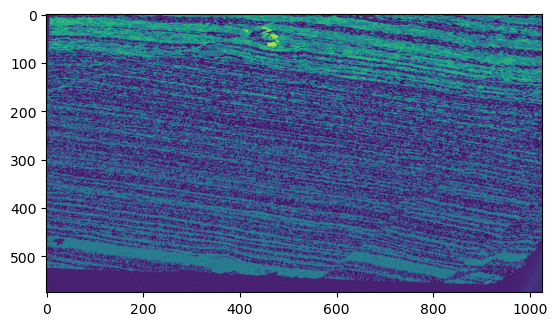

In [28]:
datafile.close()
# now we can explore the data like this:

# open file
with h5py.File(datafolder + filename, 'r') as datafile:

    # get keys
    print(datafile.keys())
    # get dataset
    dataset = datafile['RAW']
    # get dataset names
    columnNames = dataset.dtype.names
    print(columnNames)
    # see a column
    print(len(dataset['Al_map']))
    # see a pixel vector
    for pixel in range(10):
        print('Pixel @ (', dataset['x_coords'][pixel], ',', dataset['y_coords'][pixel], '):', dataset[pixel])

    # show the data
    # images are flattened, so reshape
    width = (dataset['x_coords'].max() + 1).astype(int)
    height = (dataset['y_coords'].max() + 1).astype(int)
    data_2d = dataset['Al_map'].reshape(width, height)
    plt.imshow(data_2d)
    plt.show()

# Creating the masks dataframes


|Pixel|Yes/No|(x,y) coordinate|
|---|---|---|
|0  |0  |(0,0)|
| 1 | 0 | (0,1)|
|...|...|...|
| n | 1 | (x,y)|

In [29]:
# first we load the binary masks into a list, with another list for the names
#datafile.close()
datafolder = './Aikin_Data'

# get all thin section folder names
tsNames = sorted([entry for entry in os.listdir(datafolder) 
                if os.path.isdir(os.path.join(datafolder, entry)) and 'DS_Store' not in entry])
numberOfTs = len(tsNames)


# now we can use the names list to open the files and the stacks list to store them. 
# for each thin section folder:
for ts in range(1):
    
    # get the name of the thin section
    this_tsName = tsNames[ts]
    # initialize a list to contain each map as a 1D array. 
    this_ts_data = []

    # get all the thin section's mask filenames, then remove any 
    maskNames = sorted([entry for entry in os.listdir(os.path.join(datafolder, this_tsName, 'masks'))
                if 'MineralMasks-' in entry])

    ### we'll want to clean up the filenames to make nice dataset labels
    # What are the mineral names for each mask?
    # make a list of mineral names        
    mineralNames = []
    # find the mineral names in each filename and add the mineral name to the list
    filterList = ['Albite', 'Biotite', 'Garnet', 'Kspar', 'Quartz', 'Sericite', 'WhiteMica']
    for maskName in maskNames:
        for mineral in filterList:
            if mineral.lower() in maskName.lower():
                    mineralNames.append(mineral)
        

    # iteration counter serves to allow coordinate vectors to be generated during the first iteration only.if iteration 
    iteration = 0
    # create list of column names
    columnNamesList = []

    # for each mask, load the file, turn it into an array, and append it to the list.
    for mask in maskNames:
        # open the mask
        filename = maskNames[iteration]
        rootfolder = os.path.join('./Aikin_Data', this_tsName, 'masks')
        single_tsMask = Image.open(os.path.join(rootfolder, filename))
        #plt.imshow(single_tsMask, cmap='gray')  # Adjust the colormap if needed

        # as numpy array
        single_maskArray = np.asarray(single_tsMask)
        
        # add a coordinates vector list (x,y,z=channel) in the first iteration
        if iteration == 0:

            # get the coordinates of each pixel
            x_coords = []
            y_coords = []
            x, y = single_maskArray.shape
            for i in range(x):
                for j in range(y):
                        coords = [i,j]
                        x_coords.append(coords[0])
                        y_coords.append(coords[1])

            x_coords = np.array(x_coords, dtype=np.float32)
            y_coords = np.array(y_coords, dtype=np.float32)

            this_ts_data.append(x_coords)
            this_ts_data.append(y_coords)
            columnNamesList.append('x_coords')
            columnNamesList.append('y_coords')
            
        # and flattened
        flattened_maskArray = np.ndarray.flatten(single_maskArray)

        # pixels that are part of a mineral mask are currently '0', and pixels that are not the mineral are '1'.
        # in order to apply the mask to the raw data, we'll need to first flip that (so that non-mask pixels can be removed as 0s)
        flattened_maskArray = flattened_maskArray * (-1) + 1
        # append the flattened map to the list
        this_ts_data.append(flattened_maskArray)
        
        # add the column name to the columnNameList
        columnName = str(mineralNames[iteration]) + '_mask'
        columnNamesList.append(columnName)
        iteration += 1
    #print(columnNamesList)
    #print(maskNames)
    #print(this_ts_data)
    # this bit lets us label the individual data arrays as dtype fields, so we can call them as dset['field']
    # use columnNamesList to define dtype for rec_arr
    ds_dt = np.dtype({'names':columnNamesList,'formats':[float]*len(columnNamesList)})
    # make rec_array
    if len(columnNamesList) != 0:
        rec_arr = np.rec.fromarrays(this_ts_data, dtype=ds_dt)

    filename = '/' + this_tsName + '_data.h5'
    # create an HDF5 file to store the dataframes into in the loop
    datafile = h5py.File(datafolder + filename, 'a') # the 'a' is for edit mode
    # create a group for each dataset (at this level of complexity we don't need to; all datasets can be in the root folder)
    #raw_datagroup = datafile.create_group('binary_masks')

    # add the data to the hpf5 file by creating a dataset in the RAW data group for this thin section
    dset = datafile.require_dataset('binary_masks', shape= rec_arr.shape, dtype=rec_arr.dtype, data=rec_arr)
    dset.attrs['original_dimensions'] = single_maskArray.shape
    dset.attrs['columns'] = columnNamesList
    dset.attrs['name'] = this_tsName + '_binary_mineral_masks'
    dset.attrs['description'] = 'This dataset contains 7 flattened binary rasters of the same shape as the RAW data.' + 'Currently, this dataset only exists for ' + this_tsName + '. This dataset is used to filter the map data by element, which will serve as labelled model training data'
    dset.attrs['length'] = flattened_maskArray.shape
    print(datafile.keys())
    datafile.close()


<KeysViewHDF5 ['RAW', 'binary_masks']>


<KeysViewHDF5 ['RAW', 'binary_masks']>
('x_coords', 'y_coords', 'Albite_mask', 'Biotite_mask', 'Garnet_mask', 'Kspar_mask', 'Quartz_mask', 'Sericite_mask', 'WhiteMica_mask')
[0. 0. 0. ... 0. 0. 0.]
Pixel @ ( 0.0 , 0.0 ): (0., 0., 0., 0., 0., 0., 0., 0., 0.)
Pixel @ ( 0.0 , 1.0 ): (0., 1., 0., 0., 0., 0., 0., 0., 0.)
Pixel @ ( 0.0 , 2.0 ): (0., 2., 0., 0., 0., 0., 0., 0., 0.)
Pixel @ ( 0.0 , 3.0 ): (0., 3., 0., 0., 0., 0., 0., 0., 0.)
Pixel @ ( 0.0 , 4.0 ): (0., 4., 0., 0., 0., 0., 0., 0., 0.)
Pixel @ ( 0.0 , 5.0 ): (0., 5., 0., 0., 0., 0., 0., 0., 0.)
Pixel @ ( 0.0 , 6.0 ): (0., 6., 0., 0., 0., 0., 0., 0., 0.)
Pixel @ ( 0.0 , 7.0 ): (0., 7., 0., 0., 0., 0., 0., 0., 0.)
Pixel @ ( 0.0 , 8.0 ): (0., 8., 0., 0., 0., 0., 0., 0., 0.)
Pixel @ ( 0.0 , 9.0 ): (0., 9., 0., 0., 0., 0., 0., 0., 0.)


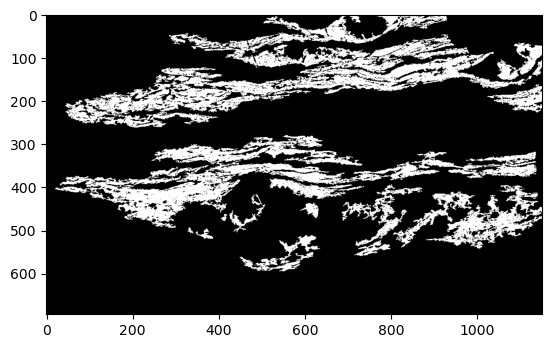

<KeysViewHDF5 ['RAW', 'binary_masks']>


In [30]:
datafile.close()
# now we can explore the data like this:

# open file
with h5py.File(datafolder + filename, 'r') as datafile:

    # get keys
    print(datafile.keys())
    # get dataset
    dataset = datafile['binary_masks']
    # get dataset names
    columnNames = dataset.dtype.names
    print(columnNames)
    # see a column
    print(dataset['Albite_mask'])
    # see a pixel vector
    for pixel in range(10):
        print('Pixel @ (', dataset['x_coords'][pixel], ',', dataset['y_coords'][pixel], '):', dataset[pixel])

    # show the data
    # images are flattened, so reshape
    width = (dataset['x_coords'].max() + 1).astype(int)
    height = (dataset['y_coords'].max() + 1).astype(int)
    data_2d = dataset['Biotite_mask'].reshape(width, height)
    plt.imshow(data_2d, cmap='gray')
    plt.show()
    print(datafile.keys())

# Make training data: applying the masks to the maps

We use only the first thin section of the hot block (`'78.7-10-1_Hot'`) for training data at this time. 

We have seven mineral masks for this thin section, and 9 element maps.
With each mask, we'll create a new dataset of masked element maps. 
The result will be a new group in the thin section's HDF5 file, `'masked_maps'`, containing 7 mineral_mask datasets with 9 columns each.

In [31]:
#datafile.close()
# next, we'll want to open the file, access the raw data and the binary masks, and multiply them together into new masked datasets.
datafolder = './Aikin_data'
filepath = '/78.7-10-1_Hot_data.h5'

# open the file
with h5py.File(datafolder + filepath, 'a') as datafile:

    # create the group
    maskedmaps_group = datafile.require_group('masked_maps')
    maskedmaps_group.attrs['description'] = ' This group contains the masked element maps. In this group there is a dataset ' + ' for each of seven minerals, and each dataset contains 9 masked, flattened element maps.'
    # get the raw and mask datasets
    raw_ds = datafile['RAW']
    bm_ds = datafile['binary_masks']

    # Extract column names from their dtypes
    raw_columnNames = raw_ds.dtype.names
    bm_columnNames = bm_ds.dtype.names
    
    # for each mineral mask, multiply every column of the raw data and save it to a new mask. 
    # name the new dataset after the mineral mask, and the columns after the map names.
    iteration = 0
    for mask in bm_columnNames[2:]:
        this_mask = bm_ds[mask]
        masked_mapList = []
        new_columnNames = []
        masked_mapList.append(np.asarray(raw_ds['x_coords']))
        masked_mapList.append(np.asarray(raw_ds['y_coords']))
        new_columnNames.append('x_coords')
        new_columnNames.append('y_coords')
          
        for map in raw_columnNames[2:]:
            this_map = raw_ds[map]
            masked_map = this_map * this_mask
            masked_mapList.append(masked_map)
            columnName = 'masked_' + map
            new_columnNames.append(map)
            #print(mask, map, np.count_nonzero(masked_map))
    

        filtered_masked_mapList = []
        # remove elements where this_mask is 0
        for array in masked_mapList:
            filtered_array = array[this_mask != 0]
            filtered_masked_mapList.append(filtered_array)
        # we can check to make sure this worked
        # print('m0:', masked_mapList[0].shape)
        # print('m1:', masked_mapList[1].shape)
        # print('m2:', masked_mapList[1].shape)
        # print('f0:', filtered_masked_mapList[0].shape)
        # print('f1:', filtered_masked_mapList[1].shape)
        # print('f2:', filtered_masked_mapList[1].shape)
        

        # this bit lets us label the individual data arrays as dtype fields, so we can call them as dset['field']
        # use columnNamesList to define dtype for rec_arr
        ds_dt = np.dtype({'names':new_columnNames,'formats':[np.float32]*len(new_columnNames)})
        # make rec_array
        rec_arr = np.rec.fromarrays(filtered_masked_mapList, dtype=ds_dt)

       
        # add the data to the hpf5 file by creating a dataset in the RAW data group for this thin section 
        # (we use 'require' so that it's only created if it doesn't exist yet)
        dataset_name = mask[:-5] + '_maps'
        masked_dset = maskedmaps_group.require_dataset(dataset_name, shape=rec_arr.shape, dtype=rec_arr.dtype, data=rec_arr)
        
        bmasks = datafile['binary_masks']
        od = list(bmasks.attrs['original_dimensions'])
        print(od)
        masked_dset.attrs['original_dimensions'] = (od[0], od[1]) # needs fixed
        masked_dset.attrs['columns'] = new_columnNames
        masked_dset.attrs['name'] =  'masked_element_maps_training_data'
        masked_dset.attrs['description'] = 'This dataset contains 9 elemental maps that have been masked by ' + mask + 'of thin section Hot block 1.' + 'This is the training data.'
        masked_dset.attrs['length'] = masked_mapList[0].shape
        
        print(masked_dset.attrs.keys())
        #print(masked_dset.dtype.names)
    print(maskedmaps_group.keys())
datafile.close()


[695, 1152]
<KeysViewHDF5 ['columns', 'description', 'length', 'name', 'original_dimensions']>
[695, 1152]
<KeysViewHDF5 ['columns', 'description', 'length', 'name', 'original_dimensions']>
[695, 1152]
<KeysViewHDF5 ['columns', 'description', 'length', 'name', 'original_dimensions']>
[695, 1152]
<KeysViewHDF5 ['columns', 'description', 'length', 'name', 'original_dimensions']>
[695, 1152]
<KeysViewHDF5 ['columns', 'description', 'length', 'name', 'original_dimensions']>
[695, 1152]
<KeysViewHDF5 ['columns', 'description', 'length', 'name', 'original_dimensions']>
[695, 1152]
<KeysViewHDF5 ['columns', 'description', 'length', 'name', 'original_dimensions']>
<KeysViewHDF5 ['Albite_maps', 'Biotite_maps', 'Garnet_maps', 'Kspar_maps', 'Quartz_maps', 'Sericite_maps', 'WhiteMica_maps']>


In [32]:

# next, we'll want to open the file, access the raw data and the binary masks, and multiply them together into new masked datasets.
datafolder = './Aikin_data'
filepath = '/78.7-10-1_Hot_data.h5'
#open the file
with h5py.File(datafolder + filepath, 'a') as datafile:
    # get the mask dataset
    bm_ds = datafile['binary_masks']

    # Extract column names from their dtypes
    bm_columnNames = bm_ds.dtype.names
    mineralNames = bm_columnNames[2:]
    width = (bm_ds['x_coords'].max() + 1).astype(int)
    height = (bm_ds['y_coords'].max() + 1).astype(int)
    allMasks_array = np.zeros((width, height), dtype=object)
    iteration = 0
    for mask in mineralNames:
        mask_array = bm_ds[mask]
            
        x = bm_ds['x_coords'].astype(int)
        y = bm_ds['y_coords'].astype(int)
            
        mask_mineral = mask.replace(' mask', '')
        for pixel, value in enumerate(mask_array):
            xc = x[pixel].item()
            yc = y[pixel].item()
            if mask_array[pixel] == 1:
                allMasks_array[xc, yc] = iteration
        iteration += 1

    print(type(allMasks_array))

    data_flat = allMasks_array.flatten()
    data_final = data_flat.astype(int)

    
    x_coords = bm_ds[bm_columnNames[0]]
    y_coords = bm_ds[bm_columnNames[1]]
    print(x_coords)
    print(y_coords)

    data = [x_coords, y_coords, data_flat]

    # this bit lets us label the individual data arrays as dtype fields, so we can call them as dset['field']
    # use columnNamesList to define dtype for rec_arr
    ds_dt = np.dtype({'names':['x_coords', 'y_coords', 'mineral_labels'],'formats':[np.float32]*3})
    # make rec_array
    rec_arr = np.rec.fromarrays(data, dtype=ds_dt)

    # save the new dataset to the hdf5 file under 'masked_maps'
    datagroup = datafile['masked_maps']
    dataset_name = 'mineral_labels'
    masked_dset = datagroup.require_dataset(dataset_name, shape=rec_arr.shape, dtype=rec_arr.dtype, data=rec_arr)
    #print(masked_dset.dtype.names)
    print(datagroup.keys())
datafile.close()
print(mineralNames)

<class 'numpy.ndarray'>
[  0.   0.   0. ... 694. 694. 694.]
[0.000e+00 1.000e+00 2.000e+00 ... 1.149e+03 1.150e+03 1.151e+03]
<KeysViewHDF5 ['Albite_maps', 'Biotite_maps', 'Garnet_maps', 'Kspar_maps', 'Quartz_maps', 'Sericite_maps', 'WhiteMica_maps', 'mineral_labels']>
('Albite_mask', 'Biotite_mask', 'Garnet_mask', 'Kspar_mask', 'Quartz_mask', 'Sericite_mask', 'WhiteMica_mask')


In [34]:
datafile.close()
# now we can explore the data like this:
filepath = './Aikin_Data/78.7-10-1_Hot_data.h5'
# open file
with h5py.File(filepath, 'r') as datafile:

    # get keys
    print(datafile.keys())
    # get dataset
    datagroup = datafile['masked_maps']
    print(datagroup.keys())
    dataset = datagroup['Biotite_maps']
    # get dataset names
    columnNames = dataset.dtype.names
    print(columnNames)
    # see a column
    print(dataset['Al_map'])
    # see a pixel vector
    for pixel in range(10):
        print('Pixel @ (', dataset['x_coords'][pixel], ',', dataset['y_coords'][pixel], '):', dataset[pixel])

    # show the data
    # images are flattened, so reshape
    width = (dataset['x_coords'].max() + 1).astype(int)
    height = (dataset['y_coords'].max() + 1).astype(int)
    #data_2d = dataset['Al_map'].reshape(width, height)
    #plt.imshow(data_2d, cmap='gray')
    #plt.show()
    print(datafile.keys())
datafile.close()

<KeysViewHDF5 ['RAW', 'binary_masks', 'masked_maps']>
<KeysViewHDF5 ['Albite_maps', 'Biotite_maps', 'Garnet_maps', 'Kspar_maps', 'Quartz_maps', 'Sericite_maps', 'WhiteMica_maps', 'mineral_labels']>
('x_coords', 'y_coords', 'Al_map', 'Ca_map', 'Ce_map', 'Fe_map', 'K_map', 'Mg_map', 'Si_map', 'Ti_map', 'Y_map', 'Zr_map')
[354. 318. 298. ... 308. 354. 326.]
Pixel @ ( 0.0 , 697.0 ): (0., 697., 354., 84., 10., 79., 203., 358., 423., 87.00001, 40., 0.)
Pixel @ ( 0.0 , 698.0 ): (0., 698., 318., 89., 11., 85., 169., 357., 429., 79., 23., 0.)
Pixel @ ( 0.0 , 699.0 ): (0., 699., 298., 71., 7., 121., 174., 232., 486., 47., 29.999998, 2.)
Pixel @ ( 0.0 , 701.0 ): (0., 701., 362., 79., 7., 126., 221., 369., 484., 54.000004, 29., 0.)
Pixel @ ( 0.0 , 702.0 ): (0., 702., 352., 76., 11., 114., 194., 385., 422., 65., 29.999998, 0.)
Pixel @ ( 0.0 , 703.0 ): (0., 703., 296., 76., 5., 98., 201., 337., 400., 72., 29., 0.)
Pixel @ ( 0.0 , 704.0 ): (0., 704., 306., 81., 12., 95., 191., 357., 409., 72., 40., 1

The code works cleanly up to this point. It has now created:

- An HDF5 file for each thin section containing:
    - **Raw data**: A 'RAW maps' dataset containing:
        - A flattened np.array of each element map (columns), with labels
        - A vector of element values for each pixel (rows)
    - A 'binary masks' dataset containing
        - A partial binary mask for each major mineral for data labelling
    - **Labelled training data**: A 'masked maps' group containing: 
        - A 'mineral mask' dataset for each mineral mask containing:
            - A masked flattened np.array of each element map (columns), with labels
            - A vector of element values for each pixel (rows)


# Opening HDF5 datasets in Pandas

Pandas has a built-in function for this purpose:
`pandas.read_hdf(filepath, key=groupname_string, mode='r')`

We'll load all of the minerals' maps into a dict of mineral:array value pairs, plus indices and coordinates. 

In [42]:
filepath = './Aikin_Data/78.7-10-1_Hot_data.h5'
groupname = 'masked_maps'
with h5py.File(filepath, 'r') as datafile:
    print(datafile.keys())
    group = datafile[groupname]
 
    dset_names = list(group.keys())
    dset_values = list(group.values())
    print(dset_names)
    print(dset_values)
    # create a dict for the pandas dataframes
masked_maps = {}
for mineralMap in dset_names:
    dataset_path = f"{groupname}/{mineralMap}"
    df = pd.read_hdf(filepath, key=dataset_path, mode='r')
    masked_maps[mineralMap] = df

mineralKeys = list(masked_maps.keys())
print(mineralKeys)
masked_maps[mineralKeys[3]].head()

<KeysViewHDF5 ['RAW', 'binary_masks', 'masked_maps']>
['Albite_maps', 'Biotite_maps', 'Garnet_maps', 'Kspar_maps', 'Quartz_maps', 'Sericite_maps', 'WhiteMica_maps', 'mineral_labels']
[<HDF5 dataset "Albite_maps": shape (5507,), type "|V48">, <HDF5 dataset "Biotite_maps": shape (157739,), type "|V48">, <HDF5 dataset "Garnet_maps": shape (20174,), type "|V48">, <HDF5 dataset "Kspar_maps": shape (1019,), type "|V48">, <HDF5 dataset "Quartz_maps": shape (8558,), type "|V48">, <HDF5 dataset "Sericite_maps": shape (7401,), type "|V48">, <HDF5 dataset "WhiteMica_maps": shape (142519,), type "|V48">, <HDF5 dataset "mineral_labels": shape (800640,), type "|V12">]
['Albite_maps', 'Biotite_maps', 'Garnet_maps', 'Kspar_maps', 'Quartz_maps', 'Sericite_maps', 'WhiteMica_maps', 'mineral_labels']


,x_coords,y_coords,Al_map,Ca_map,Ce_map,Fe_map,K_map,Mg_map,Si_map,Ti_map,Y_map,Zr_map
0,416.0,147.0,251.0,67.0,9.0,26.0,187.0,33.000000,576.0,10.0,38.000000,1.0
1,416.0,149.0,275.0,82.0,8.0,32.0,197.0,162.000015,527.0,9.0,22.000000,0.0
2,416.0,150.0,273.0,75.0,12.0,19.0,185.0,125.000000,537.0,6.0,28.000000,0.0
3,416.0,151.0,279.0,71.0,5.0,17.0,185.0,130.000000,551.0,8.0,25.000000,1.0
4,416.0,152.0,296.0,77.0,9.0,19.0,196.0,132.000000,548.0,12.0,29.999998,0.0


In [67]:
# Let's add the mineral identifiers to the column names
print(masked_maps.keys())
for mineral in masked_maps:
    print(mineral)
    df = masked_maps[mineral]
    dfKeys = df.keys()
    print(dfKeys)
    for item in dfKeys:
        print(item)
        print('H1_' + mineral + '_' + item)
        df = df.rename(columns={item: 'H1_' + key + '_' + item})
        #print(df.keys())
#df.head()
#masked_maps['Garnet_maps'].head()


dict_keys(['Albite_maps', 'Biotite_maps', 'Garnet_maps', 'Kspar_maps', 'Quartz_maps', 'Sericite_maps', 'WhiteMica_maps', 'mineral_labels'])
Albite_maps
Index(['x_coords', 'y_coords', 'Al_map', 'Ca_map', 'Ce_map', 'Fe_map', 'K_map',
       'Mg_map', 'Si_map', 'Ti_map', 'Y_map', 'Zr_map'],
      dtype='object')
x_coords
H1_Albite_maps_x_coords
y_coords
H1_Albite_maps_y_coords
Al_map
H1_Albite_maps_Al_map
Ca_map
H1_Albite_maps_Ca_map
Ce_map
H1_Albite_maps_Ce_map
Fe_map
H1_Albite_maps_Fe_map
K_map
H1_Albite_maps_K_map
Mg_map
H1_Albite_maps_Mg_map
Si_map
H1_Albite_maps_Si_map
Ti_map
H1_Albite_maps_Ti_map
Y_map
H1_Albite_maps_Y_map
Zr_map
H1_Albite_maps_Zr_map
Biotite_maps
Index(['x_coords', 'y_coords', 'Al_map', 'Ca_map', 'Ce_map', 'Fe_map', 'K_map',
       'Mg_map', 'Si_map', 'Ti_map', 'Y_map', 'Zr_map'],
      dtype='object')
x_coords
H1_Biotite_maps_x_coords
y_coords
H1_Biotite_maps_y_coords
Al_map
H1_Biotite_maps_Al_map
Ca_map
H1_Biotite_maps_Ca_map
Ce_map
H1_Biotite_maps_Ce_map
Fe_map


In [71]:
# let's just work with one df for now

df = masked_maps[mineralKeys[-2]]
#print(df.mineral_labels)
# see all unique values in a series
#sorted(df['mineral_labels'].unique().astype(int))
df.describe()


,x_coords,y_coords,Al_map,Ca_map,Ce_map,Fe_map,K_map,Mg_map,Si_map,Ti_map,Y_map,Zr_map
count,142519.000000,142519.000000,142519.000000,142519.000000,142519.000000,142519.000000,142519.000000,142519.000000,142519.000000,142519.000000,142519.000000,142519.000000
mean,390.076263,605.106140,434.316040,71.744408,8.297883,25.758747,178.510315,67.554810,445.716095,35.452404,27.848618,0.434426
std,155.580246,303.772247,32.164997,9.184032,5.942407,13.271705,14.797355,45.277111,25.774029,51.596504,14.924451,1.542316
min,45.000000,0.000000,223.000000,37.000000,0.000000,3.000000,105.000000,1.000000,234.000000,1.000000,2.000000,0.000000
25%,279.000000,306.000000,417.000000,66.000000,6.000000,18.000000,169.000000,38.000000,430.000000,18.000000,24.000000,0.000000
50%,357.000000,674.000000,435.000000,72.000000,8.000000,22.000000,179.000000,52.000004,445.000000,24.000000,26.999998,0.000000
75%,547.000000,863.000000,454.000000,77.000000,10.000000,28.000000,188.000000,79.000000,461.000000,32.000000,30.999998,1.000000
max,694.000000,1151.000000,662.000000,331.000000,431.000000,258.000000,250.000000,356.000000,657.000000,1360.000000,1565.000000,113.000000


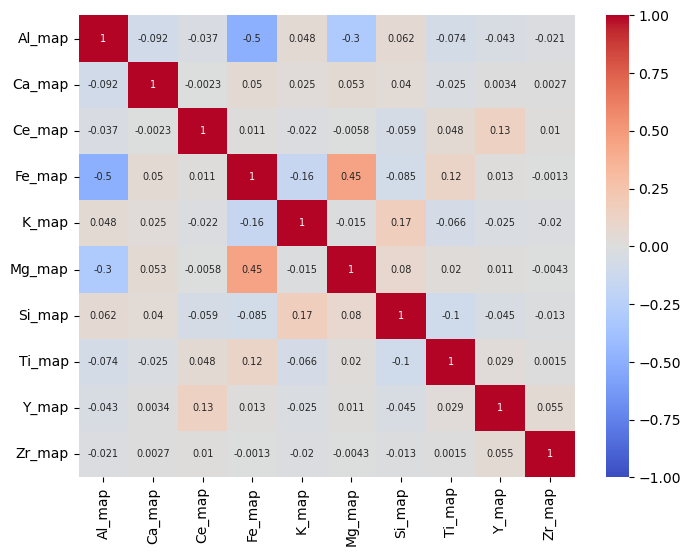

In [77]:
import seaborn as sns

elements = df.iloc[:, 2:]
correlation_matrix = elements.corr()

# Plot the heatmap using seaborn
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, annot_kws={"size": 7})
# Show the plot
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


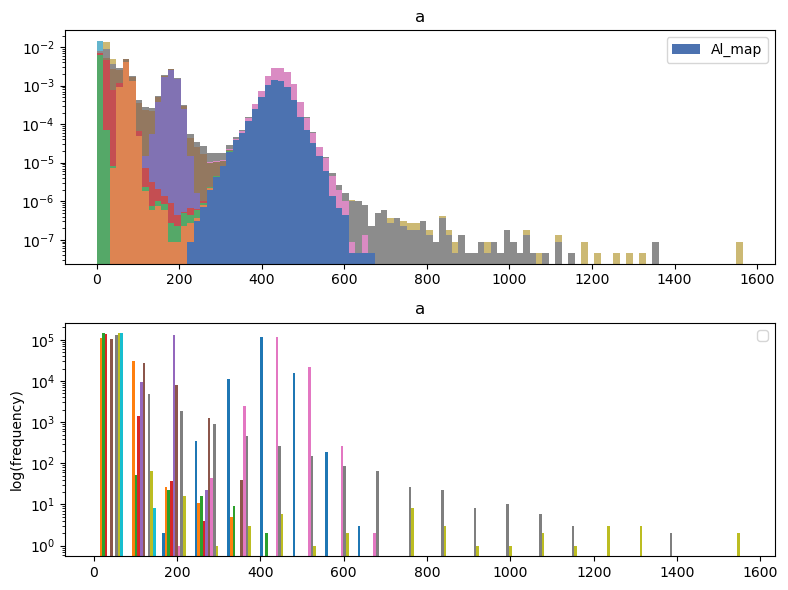

In [130]:


# create stacked histograms
fig, ((ax0, ax1)) = plt.subplots(nrows=2, ncols=1, figsize=(8,6))

# use Seaborn color palette "Set1"
colors = sns.color_palette("deep")[0:10]

ax0.hist(elements.iloc[:,:], bins=100, density=True, color=colors, alpha=1, label=elements.iloc[:,series].name, stacked=True)
ax0.set_title('')
ax0.set_yscale('log')
ax0.legend()
ax0.set_title('a')
ax0.set_xlabel('')
ax0.set_ylabel('')
ax0.legend(prop={'size': 10})

# Make a multiple-histogram of data-sets with different length.
ax1.hist(elements.iloc[:,:], bins=20, histtype='bar')
ax1.set_title('different sample sizes')
ax1.set_yscale('log')
ax1.legend()
ax1.set_title('a')
ax1.set_xlabel('')
ax1.set_ylabel('log(frequency)')
ax1.legend(prop={'size': 10})
fig.tight_layout()
plt.show()



IndexError: list index out of range

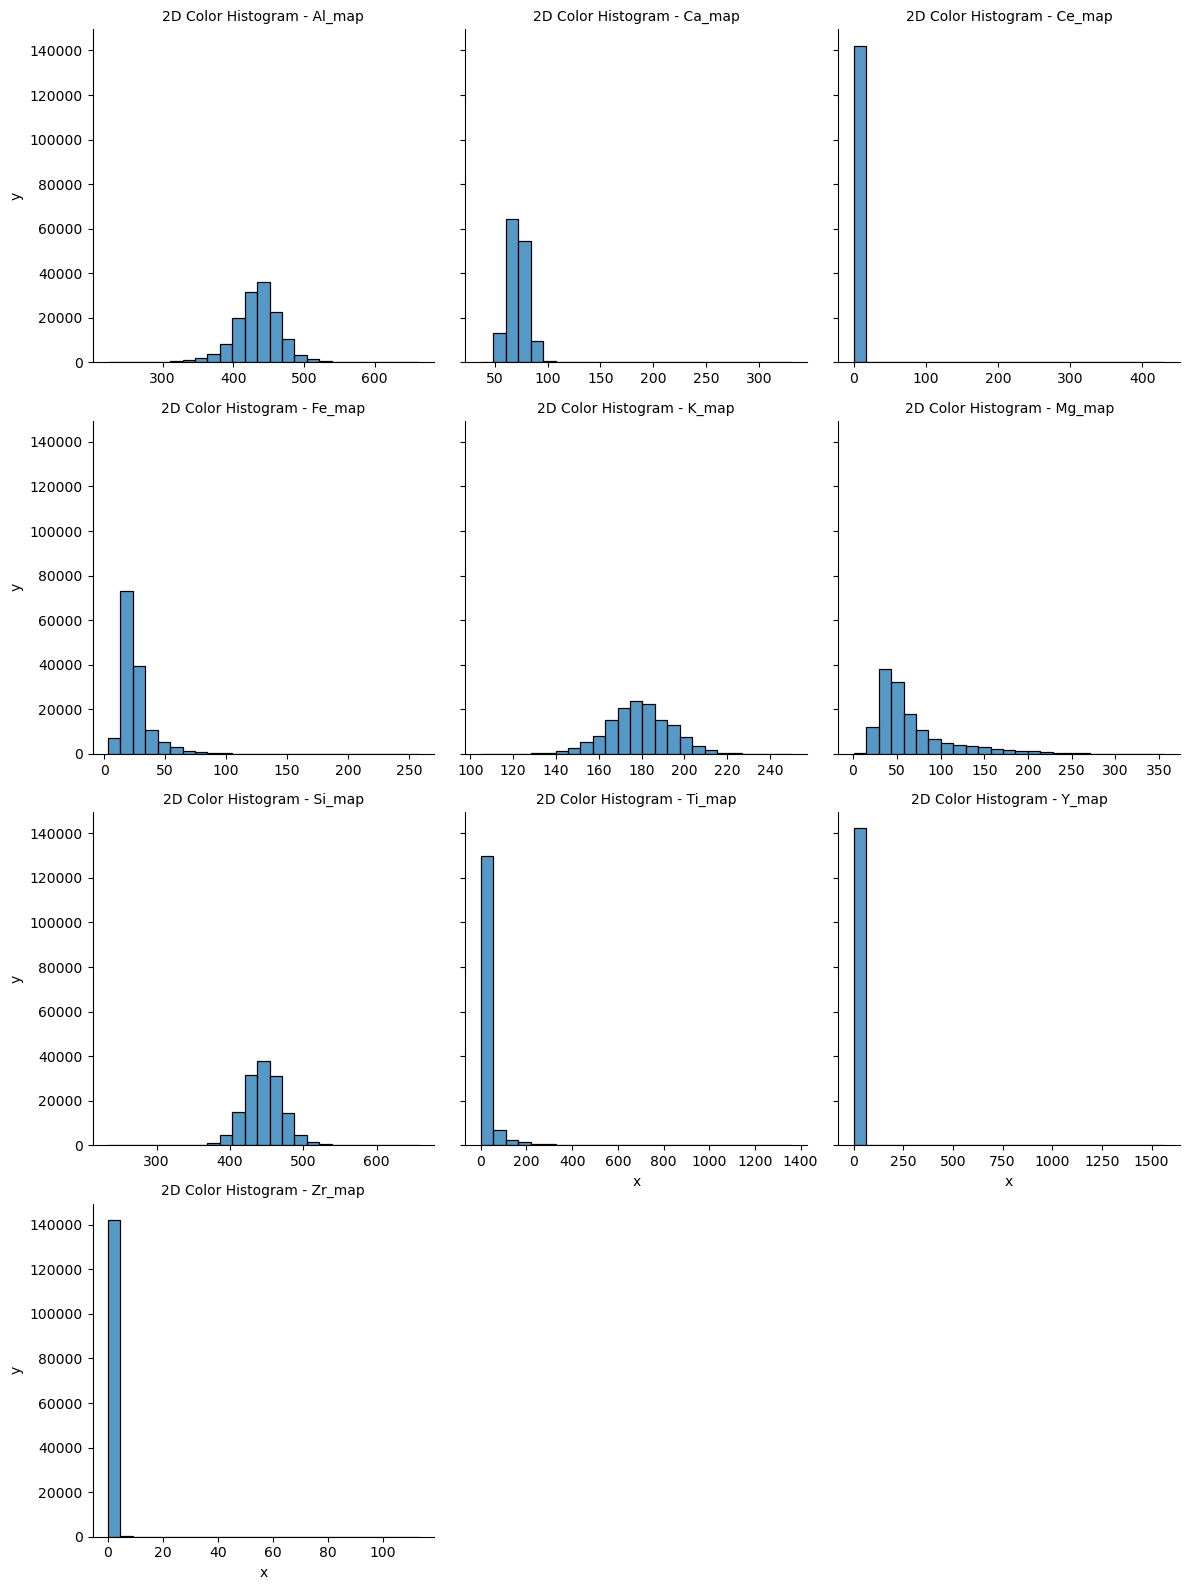

In [143]:
# Use Seaborn color palette "viridis"
colors = sns.color_palette("viridis")

# Create a FacetGrid for 2D histograms
g = sns.FacetGrid(elements.melt(), col='variable', col_wrap=3, height=4, sharex=False)
g.map(sns.histplot, 'value', bins=25)
# Set axis labels and plot title
g.set_axis_labels('x', 'y')
g.set_titles('2D Color Histogram - {col_name}')

# Add colorbar
g.fig.colorbar(g.axes[0].collections[0], ax=g.axes, location='right', pad=0.02)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

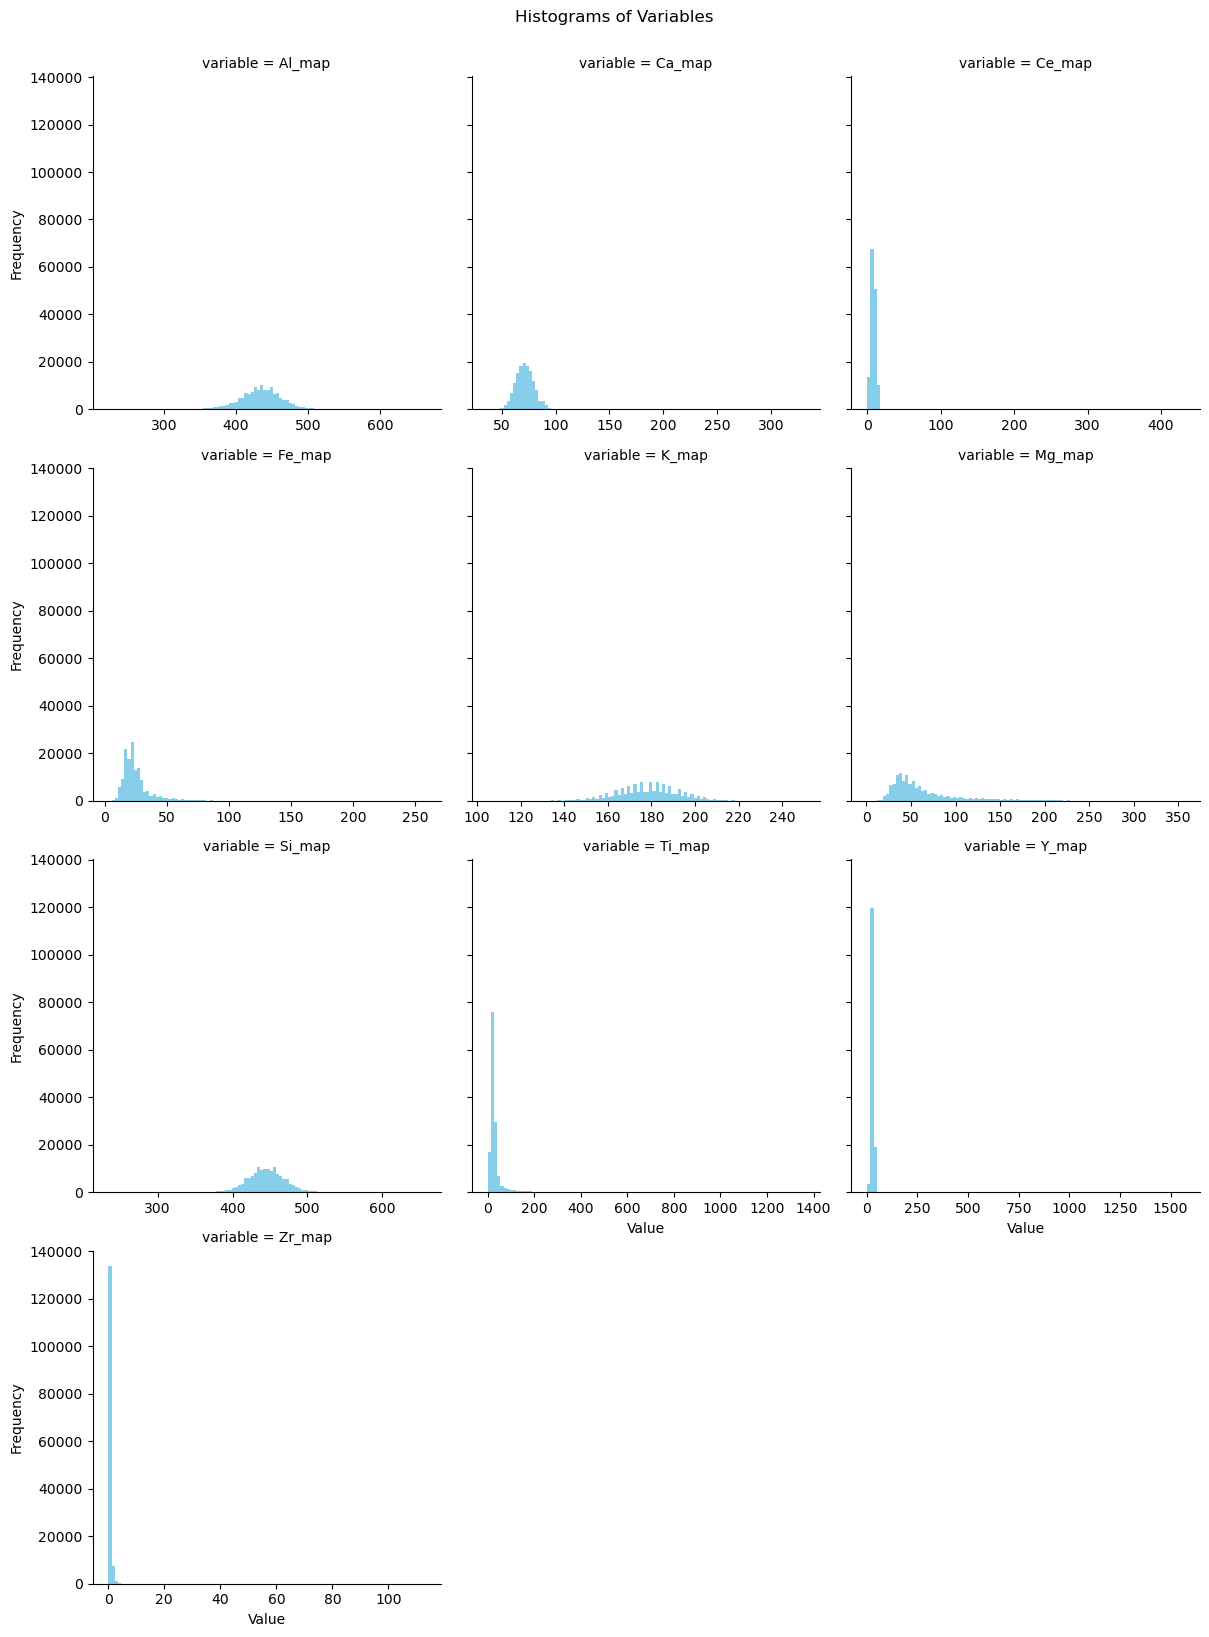

In [86]:
# Create a FacetGrid of histograms for each series
g = sns.FacetGrid(elements.melt(value_vars=elements.columns), col='variable', col_wrap=3, height=4, sharex=False)
g.map(plt.hist, 'value', bins=100, color='skyblue')

# Set axis labels and plot title
g.set_axis_labels('Value', 'Frequency')
g.fig.suptitle('Histograms of Variables', y=1.02)

# Show the plot
plt.show()

# Data exploration


### Statistical analysis



In [46]:
df.describe()

,x_coords,y_coords,mineral_labels
count,800640.000000,800640.000000,800640.000000
mean,347.000000,575.500000,1.406475
std,200.629135,332.553833,2.265771
min,0.000000,0.000000,0.000000
25%,173.000000,287.750000,0.000000
50%,347.000000,575.500000,0.000000
75%,521.000000,863.250000,1.000000
max,694.000000,1151.000000,6.000000


### Histograms

<KeysViewHDF5 ['RAW', 'binary_masks', 'masked_maps']>
<KeysViewHDF5 ['Albite_maps', 'Biotite_maps', 'Garnet_maps', 'Kspar_maps', 'Quartz_maps', 'Sericite_maps', 'WhiteMica_maps', 'mineral_labels']>
Total number of biotite sample points:  157739


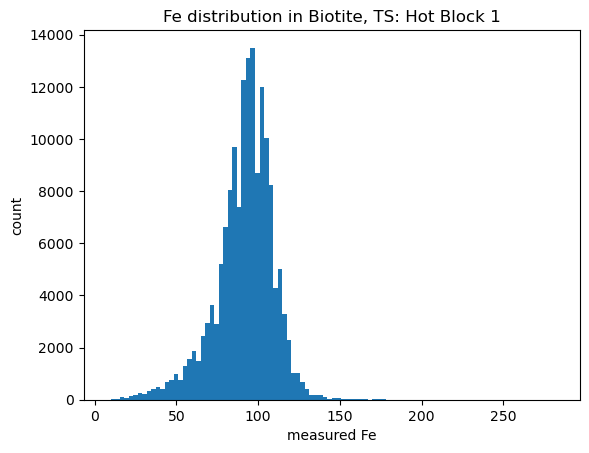

In [57]:
datafile.close()

with h5py.File(filepath, 'r') as datafile:
    print(datafile.keys())
    datagroup = datafile['masked_maps']
    print(datagroup.keys())
    iteration = 0

    dataset = datagroup['Biotite_maps']
    map = dataset['Fe_map']
    plt.hist(map, 100)
    plt.title('Fe distribution in Biotite, TS: Hot Block 1')
    plt.xlabel('measured Fe')
    plt.ylabel('count')
    print('Total number of biotite sample points: ', len(map))
datafile.close()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<KeysViewHDF5 ['RAW', 'binary_masks', 'masked_maps']>
<KeysViewHDF5 ['Albite_maps', 'Biotite_maps', 'Garnet_maps', 'Kspar_maps', 'Quartz_maps', 'Sericite_maps', 'WhiteMica_maps', 'mineral_labels']>


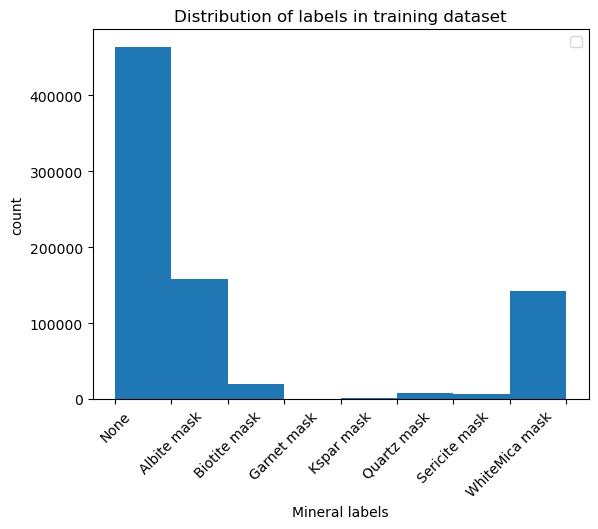

In [58]:
datafile.close()
filepath = './Aikin_Data/78.7-10-1_Hot_data.h5'
with h5py.File(filepath, 'r') as datafile:
    print(datafile.keys())
    datagroup = datafile['masked_maps']
    print(datagroup.keys())
    iteration = 0

    dataset = datagroup['mineral_labels']
    map = dataset['mineral_labels']
    hist, bins, _ = plt.hist(map, 8)
    plt.title('Distribution of labels in training dataset')
    plt.xlabel('Mineral labels')
    plt.ylabel('count')
    plt.legend()
    labels = ['None', 'Albite mask', 'Biotite mask', 'Garnet mask', 'Kspar mask', 'Quartz mask', 'Sericite mask', 'WhiteMica mask','']
    plt.xticks(bins, labels, rotation=45, ha='center')
    plt.show()


datafile.close()

# oops! looks like albite and biotite and garnet are switched around. fix this!

# Opening the files



## MLGeo-Book PCA test

In [59]:
# PCA

# Import useful modules
import requests, zipfile, io, gzip, glob, os

from sklearn.decomposition import PCA
from sklearn import datasets
import sklearn
from matplotlib import cm
import numpy.linalg as ln


In [60]:
# Feature selection via parameter exploration

# Heatmap functions
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


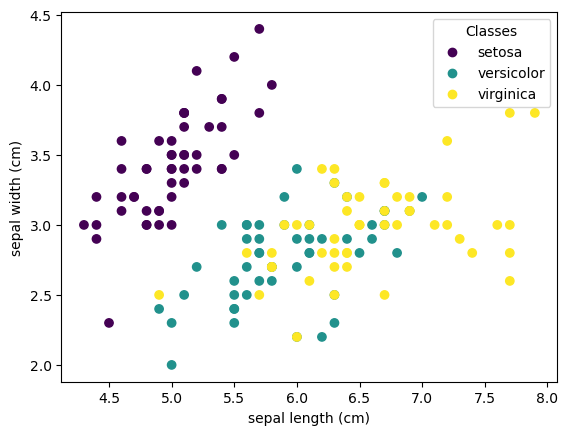

In [63]:
# Let's load in the iris dataset
iris = datasets.load_iris()

# Convert iris to a pandas dataframe...
irisDF = pd.DataFrame(data=iris.data,  
                  columns=iris.feature_names)

# Now, plot up sepal length vs width, color-coded by target (or species)

scatter = plt.scatter(irisDF['sepal length (cm)'], irisDF['sepal width (cm)'], c=iris.target)
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.legend(scatter.legend_elements()[0], iris.target_names, title="Classes")
irisDF.head()


In [67]:
label_df = masked_maps[mineralKeys[-1]]
label_df.head()

,x_coords,y_coords,mineral_labels
0,0.0,0.0,0.0
1,0.0,1.0,0.0
2,0.0,2.0,0.0
3,0.0,3.0,0.0
4,0.0,4.0,0.0


In [62]:
print(mineralKeys)
df = masked_maps[mineralKeys[3]]

['Albite_maps', 'Biotite_maps', 'Garnet_maps', 'Kspar_maps', 'Quartz_maps', 'Sericite_maps', 'WhiteMica_maps', 'mineral_labels']


,x_coords,y_coords,Al_map,Ca_map,Ce_map,Fe_map,K_map,Mg_map,Si_map,Ti_map,Y_map,Zr_map
0,416.0,147.0,251.0,67.0,9.0,26.0,187.0,33.000000,576.0,10.0,38.000000,1.0
1,416.0,149.0,275.0,82.0,8.0,32.0,197.0,162.000015,527.0,9.0,22.000000,0.0
2,416.0,150.0,273.0,75.0,12.0,19.0,185.0,125.000000,537.0,6.0,28.000000,0.0
3,416.0,151.0,279.0,71.0,5.0,17.0,185.0,130.000000,551.0,8.0,25.000000,1.0
4,416.0,152.0,296.0,77.0,9.0,19.0,196.0,132.000000,548.0,12.0,29.999998,0.0


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


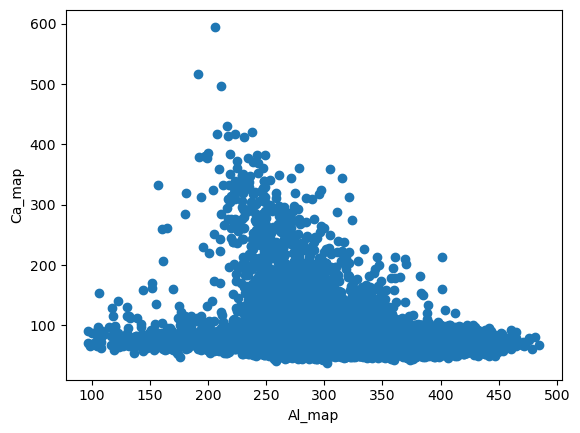

In [70]:
# Now, plot up sepal length vs width, color-coded by target (or species)

scatter = plt.scatter(df['Al_map'], df['Ca_map'])
plt.xlabel('Al_map')
plt.ylabel('Ca_map')
#plt.legend(scatter.legend_elements()[0], iris.target_names, title="Classes")
irisDF.head()

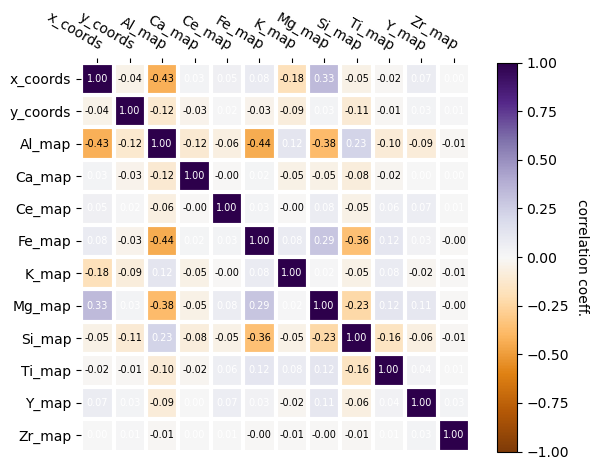

In [73]:
# Now, how might we reduce these dimensions? 
# One way is by looking at how variables are correlated
# Calculate the correlation coefficients for all variables
allCorr = df.corr()

im, _ = heatmap(allCorr, df, df,
                cmap="PuOr", vmin=-1, vmax=1,
                cbarlabel="correlation coeff.")

annotate_heatmap(im, size=7)

plt.tight_layout()
plt.show()


None of the correlation coefficients are larger than 0.44! This means that this data is still a bit broad. 

In [74]:
allCorr

,x_coords,y_coords,Al_map,Ca_map,Ce_map,Fe_map,K_map,Mg_map,Si_map,Ti_map,Y_map,Zr_map
x_coords,1.000000,-0.042453,-0.426114,0.026885,0.052058,0.079777,-0.180051,0.329294,-0.050549,-0.015021,0.073015,0.004862
y_coords,-0.042453,1.000000,-0.118351,-0.031765,0.015587,-0.034677,-0.085797,0.027288,-0.108790,-0.012319,0.025784,0.008533
Al_map,-0.426114,-0.118351,1.000000,-0.115212,-0.064139,-0.437718,0.124069,-0.377528,0.225736,-0.097953,-0.088133,-0.008761
Ca_map,0.026885,-0.031765,-0.115212,1.000000,-0.001288,0.018887,-0.048394,-0.047456,-0.078147,-0.015898,0.003683,0.000872
Ce_map,0.052058,0.015587,-0.064139,-0.001288,1.000000,0.028221,-0.000242,0.076299,-0.053672,0.057270,0.069330,0.005796
Fe_map,0.079777,-0.034677,-0.437718,0.018887,0.028221,1.000000,0.078227,0.288650,-0.355917,0.116656,0.033053,-0.002060
K_map,-0.180051,-0.085797,0.124069,-0.048394,-0.000242,0.078227,1.000000,0.015435,-0.051802,0.078876,-0.023028,-0.005200
Mg_map,0.329294,0.027288,-0.377528,-0.047456,0.076299,0.288650,0.015435,1.000000,-0.232657,0.117194,0.107036,-0.003959
Si_map,-0.050549,-0.108790,0.225736,-0.078147,-0.053672,-0.355917,-0.051802,-0.232657,1.000000,-0.158969,-0.063039,-0.010391
Ti_map,-0.015021,-0.012319,-0.097953,-0.015898,0.057270,0.116656,0.078876,0.117194,-0.158969,1.000000,0.036609,0.006674


# PCA Test 
based on [Principal Component Analysis For Image Data in Python](https://www.askpython.com/python/examples/principal-component-analysis-for-image-data)





In [1]:
print(df[0:])


NameError: name 'df' is not defined

In [93]:
data_cols = list(df.keys())[2:]
data = df[data_cols]
#print(data)
print(df[0:])
# standardize the data
df_std = (data - np.mean(data, axis=1))#/data.std()

# determine the singular vector decomposition of the covariance matrix. 
U, S, VT = np.linalg.svd(df_std.T,full_matrices=0) # may not need T (transform)
print('S: ', S)

# plot the eigenvectors over the data
fig = plt.figure()
ax2 = fig.add_subplot(111)
ax2.plot(df_std[0,:],df_std[1,:], '.', color='k', alpha=0.125)   # Plot data to overlay PCA
ax2.grid()
plt.xlim((-6, 8))
plt.ylim((-6,8))
ax2.set_aspect('equal')

# Plot eigenvectors VT[:,0] and VT[:,1]
ax2.plot(np.array([Xavg[0], Xavg[0]+VT[0,0]]),
         np.array([Xavg[1], Xavg[1]+VT[1,0]]),'-',color='cyan',linewidth=2)
ax2.plot(np.array([Xavg[0], Xavg[0]+VT[0,1]]),
         np.array([Xavg[1], Xavg[1]+VT[1,1]]),'-',color='white',linewidth=2)

plt.show()


# show first 3 PCs
n_components = 3
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(df_standardized)

pc_columns = ['PCA%i' % i for i in range(1, n_components + 1)]  # Start indexing from 1
df_pca = pd.DataFrame(data=pca_result, columns=pc_columns, index=df.index)


        x_coords  y_coords  Al_map  Ca_map     Ce_map  Fe_map  K_map  \
0            0.0     697.0   354.0    84.0  10.000000    79.0  203.0   
1            0.0     698.0   318.0    89.0  11.000000    85.0  169.0   
2            0.0     699.0   298.0    71.0   7.000000   121.0  174.0   
3            0.0     701.0   362.0    79.0   7.000000   126.0  221.0   
4            0.0     702.0   352.0    76.0  11.000000   114.0  194.0   
...          ...       ...     ...     ...        ...     ...    ...   
157734     595.0     550.0   261.0    94.0  12.000000    91.0  164.0   
157735     595.0     551.0   311.0    70.0   8.000000    84.0  139.0   
157736     595.0     552.0   308.0    56.0  14.000001    81.0  180.0   
157737     595.0     553.0   354.0    69.0   7.000000    50.0  169.0   
157738     595.0     554.0   326.0    78.0  11.000000    82.0  170.0   

            Mg_map  Si_map     Ti_map      Y_map  Zr_map  
0       358.000000   423.0  87.000008  40.000000     0.0  
1       357.00000

## File format

We are using [**HDF5**]() to store our raw and processed data, because it is well-integrated with python, works well and efficiently for large, numerical data, and allows us to store several pandas DataFrames in one file with labels, making it easy to access and recast the data. With this in mind, the data is divided by thin section, and subdivided into DataFrames in the same hierarchy as the `./data/` directory, with additional labeled DataFrames added for processed data. 

|**Data type** |description|dimensions|
|---|---|---|
|RAW/|...|...|
| masks/|...|...|
|...|...|...|


In [ ]:
import h5py

# Create an HDF5 file
with h5py.File('Aikin_ML_data', 'w') as hf: # the 'w' is for 'writing'
    # Store each DataFrame as a separate group
    for df_name, df in your_dataframes.items():
        hf.create_group(df_name)
        hf[df_name].create_dataset('data', data=df)

In [ ]:

this_ts_df['coordinates']

In [ ]:
import h5py
import pandas as pd
import numpy as np

# Create a sample DataFrame with tuples
data = {'Column1': [(1, 2), (3, 4), (5, 6)],
        'Column2': [(7, 8), (9, 10), (11, 12)]}

df = pd.DataFrame(data)

# Create an HDF5 file and store the DataFrame
with h5py.File('data.h5', 'w') as hf:
    hf.create_dataset('my_dataframe', data=df)